[Speedup inference](https://x.com/mrsiipa/status/1829429481041449339)

In [2]:
import time
import torch
import pipeline
import model_loader
from PIL import Image
from transformers import CLIPTokenizer

In [3]:
torch.set_float32_matmul_precision('medium')
print(f"Float32 MatMul Precision set to: {torch.get_float32_matmul_precision()}")

Float32 MatMul Precision set to: medium


In [4]:
DEVICE = "cpu"

ALLOW_MPS = True
ALLOW_CUDA = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.backends.mps.is_built()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

Using device: mps


In [5]:
tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

In [6]:

# Convert models to float16 if using MPS
if DEVICE == "mps":
    for name, model in models.items():
        model = model.half()  # Convert model parameters to float16
        model = model.to(memory_format=torch.channels_last)  # Convert to channels_last
        models[name] = model
    print("Converted models to float16 precision and channels_last memory format for MPS.")
else:
    print("Running on CPU with float32 precision.")


Converted models to float16 precision and channels_last memory format for MPS.


# Params

## Text to Image

In [7]:
# prompt = "A painting of a beautiful sunset over a mountain lake, ultra shart, cinematic, 8k resolution kodak gold 200 film look retro vibe"
# prompt = "A forest with a river running through it, ultra sharp, cinematic, 8k resolution, kodak gold 200 film look, retro vibe, scary monster huggy wuggy hiding in the woods"
prompt = "minecraft forest"
uncond_prompt = ""
do_cfg = True
cfg_scale = 7

## Image to Image

In [8]:
input_image = None
image_path = "../images/las.jpg"
input_image = Image.open(image_path)
strength = 0.3

sampler = "ddpm"
num_inference_steps = 50

# input_image.show()

# Generation

In [9]:
seed = torch.randint(0, 1000000, (1,)).item()
seed

967191

In [10]:
start_time = time.time()
output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)
end_time = time.time()
print(f"Time taken: {end_time - start_time}")

100%|██████████| 15/15 [00:08<00:00,  1.67it/s]


Time taken: 11.52057695388794


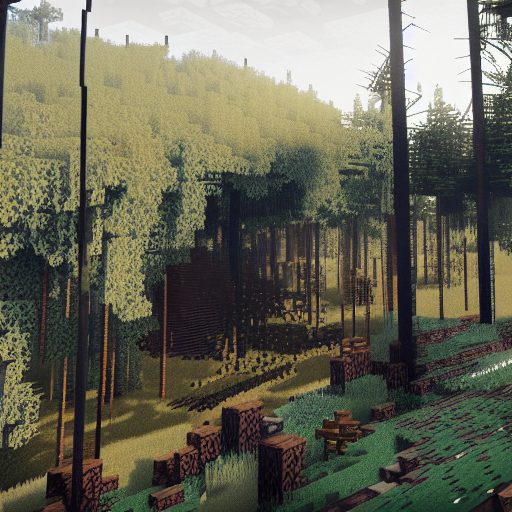

In [11]:
# Combine the input image and the output image into a single image.
Image.fromarray(output_image)